In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from CENSAr.vector_data_analysis.geoprocessing import (from_coarser_to_thiner_area, 
                                                       from_wkt)
from CENSAr.datasources import (radios_prov,
                                radios_eph_censo_2010,
                                radios_precenso_2020)

In [2]:
url = "https://storage.googleapis.com/python_mdg/censar_data/informal_settlements_072022.csv"
inf_sett = pd.read_csv(url)
inf_gdf = from_wkt(df=inf_sett, wkt_column='geometry')

In [3]:
inf_region = inf_gdf.loc[inf_gdf['provincia'].isin(['Chaco', 'Corrientes']) & 
                        (inf_gdf['departamento'].isin(['San Fernando','Capital']))]

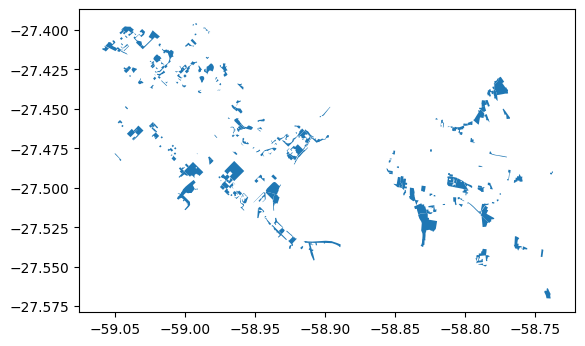

In [4]:
inf_region.plot();

## 1. Chaco - San Fernando

In [5]:
envolvente = radios_eph_censo_2010(aglo_idx="08")
chaco_2010 = radios_prov(year=2010, prov="chaco", mask=envolvente)

[11:21:28] INFO     https://storage.googleapis.com/python_mdg/censar_carto/radios_eph_json.zip   ]8;id=456168;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=752830;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#103\103]8;;\

[11:21:40] ERROR    Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.                         ]8;id=878339;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py\geodataframe.py]8;;\:]8;id=894929;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py#635\635]8;;\
                                                                                                                   

           ERROR    Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.                         ]8;id=132148;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py\geodataframe.py]8;;\:]8;id=123236;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py#635\635]8;;\
                                                                                                                   

[11:21:44] ERROR    Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.                         ]8;id=300736;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py\geodataframe.py]8;;\:]8;id=143836;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py#635\635]8;;\
                                                                                                                   

In [6]:
inf_chaco = inf_gdf.loc[(inf_gdf['provincia'].isin(['Chaco'])) & 
                        (inf_gdf['departamento'].isin(['San Fernando']))].copy()

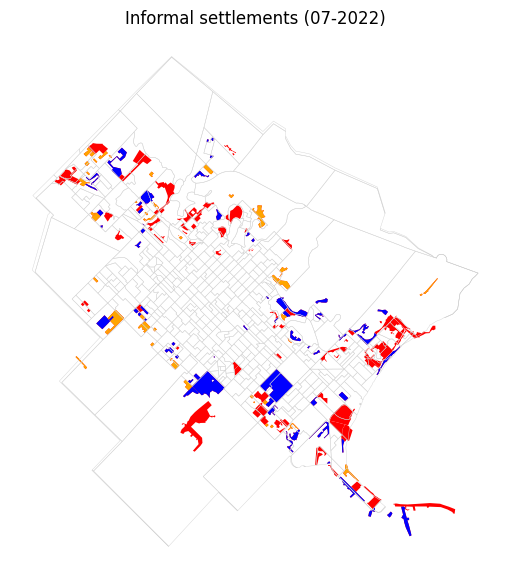

In [7]:
f, ax = plt.subplots(figsize=(10,7))
chaco_2010.geometry.boundary.plot(ax=ax, linewidth=0.3, color='lightgrey')
inf_chaco.plot(ax=ax, color='red')
# los asentamientos creados a partir de la decada del 2000
inf_chaco.loc[inf_chaco['decada_de_creacion']=='Década 2000'].plot(ax=ax, color='blue')
inf_chaco.loc[inf_chaco['decada_de_creacion']=='Década 2010'].plot(ax=ax, color='orange')

ax.set_title("Informal settlements (07-2022)")
ax.set_axis_off();

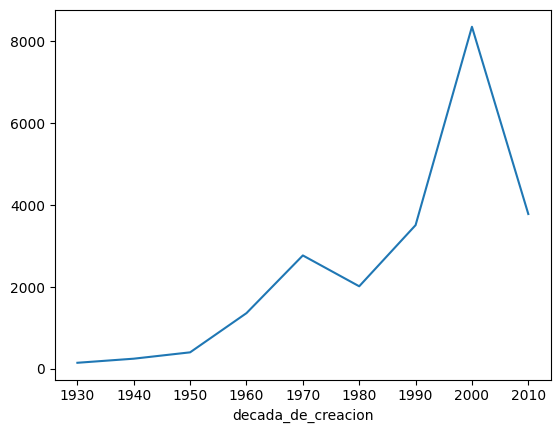

In [8]:
chaco_trend = inf_chaco.groupby('decada_de_creacion')['cantidad_viviendas_aproximadas'].sum()
chaco_trend.index = chaco_trend.index.map(lambda x: x[7:])
chaco_trend.astype(int).plot(kind='line');

In [9]:
chaco_trend

decada_de_creacion
1930     150.0
1940     250.0
1950     405.0
1960    1362.0
1970    2770.0
1980    2017.0
1990    3509.0
2000    8351.0
2010    3781.0
Name: cantidad_viviendas_aproximadas, dtype: float64

In [10]:
chaco_2010_posgar07 = chaco_2010.to_crs(5347)
inf_chaco_posgar07 = inf_chaco.to_crs(5347) 

chaco_ovl = from_coarser_to_thiner_area(coarser_geom=chaco_2010_posgar07, 
                                        thiner_geom=inf_chaco_posgar07,
                                        coarser_idx='link', 
                                        thiner_idx='id_renabap')

In [11]:
chaco_ovl.head()

,id_renabap,link,thiner_area,coarser_area,ovl_area,thiner_share,coarser_share
0,2204,221402105,86022.462977,3.331295e+05,52473.923925,61.0,15.8
1,2204,221402106,86022.462977,1.671168e+06,33548.539052,39.0,2.0
2,2207,221402105,8232.450403,3.331295e+05,8143.837784,98.9,2.4
3,2229,221402105,49231.214211,3.331295e+05,48075.574502,97.7,14.4
4,2229,221402106,49231.214211,1.671168e+06,1155.639708,2.3,0.1


In [12]:
chaco_ovl.groupby('id_renabap')['thiner_area'].last().sum()

13628567.112845728

In [13]:
inf_chaco.to_crs(5347).geometry.area.sum()

14185248.125281181

In [14]:
# La totalidad de la superficie del asentamiento 2204 ...  
chaco_ovl.loc[chaco_ovl['id_renabap']==2204]['thiner_share'].sum()

100.0

In [15]:
# ... se distribuye entre dos radios censales
chaco_ovl.loc[chaco_ovl['id_renabap']==2204]['link'].unique()

array(['221402105', '221402106'], dtype=object)

In [16]:
# Mientras que el radio 221202722 intersecta con 4 asentamientos ...
chaco_ovl.loc[chaco_ovl['link']=='221402722']

,id_renabap,link,thiner_area,coarser_area,ovl_area,thiner_share,coarser_share
55,2295,221402722,745783.669616,2.488865e+07,736308.287121,98.7,3.0
119,2277,221402722,828841.798524,2.488865e+07,828841.798524,100.0,3.3
120,2353,221402722,102666.530119,2.488865e+07,102666.530119,100.0,0.4
121,5104,221402722,75545.124363,2.488865e+07,73215.515869,96.9,0.3


In [17]:
informal_share_chaco = chaco_ovl.groupby('link')['coarser_share'].sum()
chaco_2010['informal_share'] = chaco_2010['link'].map(informal_share_chaco)

In [18]:
# ... lo que representa un 7% de su superficie 
chaco_2010.loc[chaco_2010['link']=='221402722', 'informal_share']

483    7.0
Name: informal_share, dtype: float64

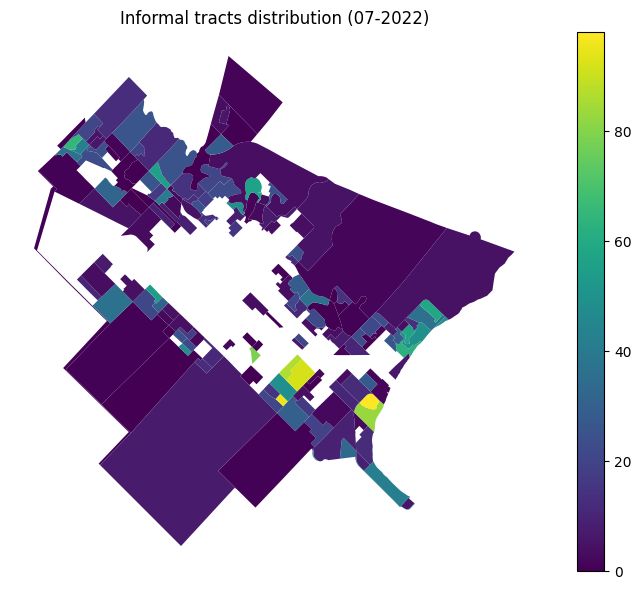

In [19]:
f, ax = plt.subplots(figsize=(10,7))
chaco_2010.plot(ax=ax, column='informal_share', legend=True)
ax.set_title("Informal tracts distribution (07-2022)")
ax.set_axis_off();

## 2. Corrientes - Capital

In [20]:
corrientes_2020 = radios_precenso_2020(
    geo_filter={"prov": "18", "depto": "021"}, mask=None
)

In [21]:
inf_ctes = inf_gdf.loc[(inf_gdf['provincia'].isin(['Corrientes'])) & 
                        (inf_gdf['departamento'].isin(['Capital']))].copy()

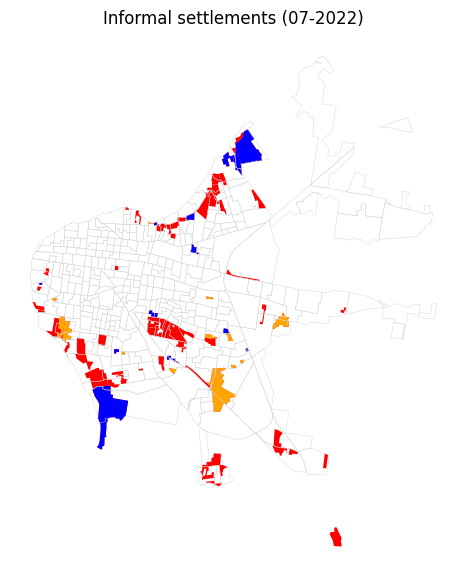

In [22]:
f, ax = plt.subplots(figsize=(10,7))
corrientes_2020.geometry.boundary.plot(ax=ax, linewidth=0.3, color='lightgrey')
inf_ctes.plot(ax=ax, color='red')
# los asentamientos creados a partir de la decada del 2000
inf_ctes.loc[inf_ctes['decada_de_creacion']=='Década 2000'].plot(ax=ax, color='blue')
inf_ctes.loc[inf_ctes['decada_de_creacion']=='Década 2010'].plot(ax=ax, color='orange')

ax.set_title("Informal settlements (07-2022)")
ax.set_axis_off();

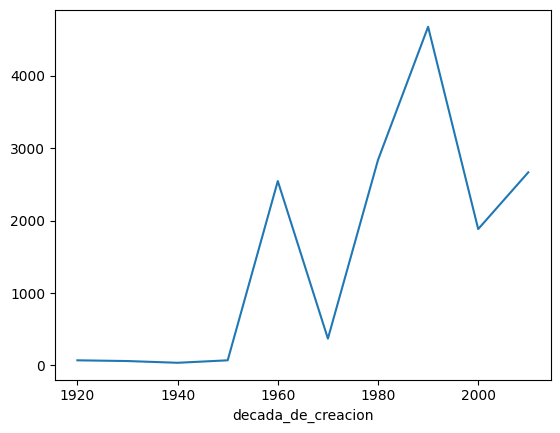

In [23]:
ctes_trend = inf_ctes.groupby('decada_de_creacion')['cantidad_viviendas_aproximadas'].sum()
ctes_trend.index = ctes_trend.index.map(lambda x: x[7:])
ctes_trend.astype(int).plot(kind='line');

In [24]:
ctes_trend

decada_de_creacion
1920      70.0
1930      60.0
1940      36.0
1950      70.0
1960    2546.0
1970     370.0
1980    2837.0
1990    4677.0
2000    1883.0
2010    2667.0
Name: cantidad_viviendas_aproximadas, dtype: float64

In [25]:
ctes_2020_posgar07 = corrientes_2020.to_crs(5347)
inf_ctes_posgar07 = inf_ctes.to_crs(5347) 

corrientes_ovl = from_coarser_to_thiner_area(coarser_geom=ctes_2020_posgar07, 
                                            thiner_geom=inf_ctes_posgar07,
                                            coarser_idx='link', 
                                            thiner_idx='id_renabap')

In [26]:
informal_share_ctes = corrientes_ovl.groupby('link')['coarser_share'].sum()
corrientes_2020['informal_share'] = corrientes_2020['link'].map(informal_share_ctes)

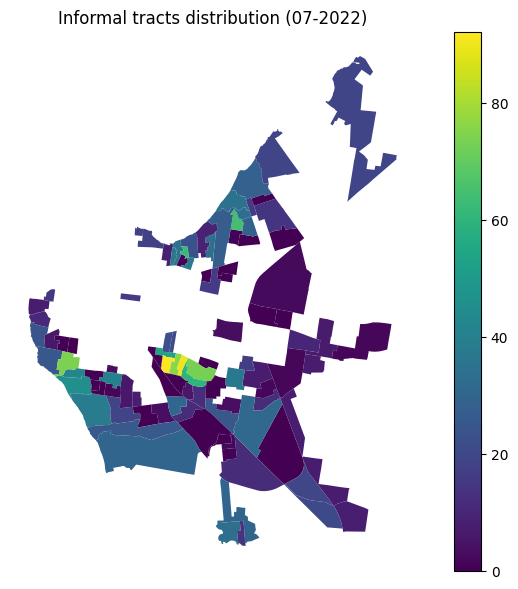

In [27]:
f, ax = plt.subplots(figsize=(10,7))
corrientes_2020.plot(ax=ax, column='informal_share', legend=True)
ax.set_title("Informal tracts distribution (07-2022)")
ax.set_axis_off();